# Airbnb - Data Preperation#

Notebook created to process data (dealing with NaN, feature reduction, one-hot encoding, and formatting).

In this notebook initial analysis is completed prior to ML methods to determine:

Q1) Does price vary seasonally across market?

## 1. Imports

In [4]:
#Import basic functions
import pandas as pd
import numpy as np

#Import for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import matplotlib.style as style

#Sklearn for data prep
from sklearn.preprocessing import MultiLabelBinarizer
import re


ModuleNotFoundError: No module named 'airbnb_pkg'

## 2. Functions

In [116]:
def plot_histogram(data, column, binsize=50, y_label='', x_label='', color='blue'):
    """
    Function to plot standard histograms (Can be used for individual or side by side plots)
    """
    # Plots the Graph with title & axis
    ax = sns.distplot(data[column], kde=False, color=color, bins=binsize)
        
    # Sets up the title based on the plotting column and the market    
    ax.set_title(f"Vancouver - Listing Prices", fontsize=25)
    
    # Sets the y and x labels
    ax.set_ylabel(y_label, fontsize=24)
    ax.set_xlabel(x_label, fontsize=24)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    
    # Removes spines and changes layout to tight
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
def plot_line(data, ax, color, alpha=.7, ls='-', lw=5, label=None):
    """
    plots the standard line graph
    """
    ax.plot(data, color=color,
            alpha=alpha, ls=ls,
            linewidth=lw, label=label)
    
    #Set the x-labels and y limits
    x_ticks = pd.to_datetime(Vancouver_CPM.index)
    
    ax.set_xticklabels([pd.to_datetime(x).strftime('%B') for x in x_ticks],
                      rotation=45,
                      fontsize=15)
    
    ax.set_xticks(x_ticks)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)
        
    #ax.set_ylim(40,100)
    #ax.tick_params(axis='y')
    
    #Plot the legend
    h1, l1 = ax.get_legend_handles_labels()
    ax.legend(loc=2, frameon=False)
    
    #Remove spines and change layout to tight
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()

In [23]:
def clean_calendar_data(data):
    """Perform basic cleaning on raw calendar data"""
    #remove NaN
    data = data.dropna()
    
    #Update formatting of prices
    data['price'] = [int(str(x).replace('$', '').replace(',','').replace('.00',''))
                    for x in data['price']]
    
    #Set Date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    #Drops extra columns
    data = data[['listing_id', 'price', 'date']]
    
    return data

In [49]:
def clean_listing_data(data):
    """Basic cleaning of raw listing data"""
    
    #Keep only columns that might influence cost, drop others (dates of reviews, host info, etc)
    keep_col = ['id', 'neighbourhood', 'zipcode', 'property_type', 
                'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
                'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 
                'monthly_price', 'number_of_reviews', 'review_scores_rating', 
                'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
                'review_scores_communication', 'review_scores_location', 'review_scores_value',
                'reviews_per_month']
    
    data = data[keep_col]
    
    #Removes columns with more than 90% of data missing & print column
    data_dpcol = data.dropna(axis=1, thresh=len(data)*0.1)
    dropped_col = set(data.columns).difference(list(data_dpcol.columns))
    print(f'Columns dropped: {dropped_col}')
    
    #Removes rows with all missing values
    data_fil = data_dpcol.dropna(axis=0, thresh=1)
    print(f'Number of rows dropped: {len(data_dpcol)-len(data_fil)}')
    
    #Formatting price columns
    data_fil['price'] = data_fil['price'].fillna(0)
    
    data_fil['price'] = [int(str(x).replace('$','').replace(',','').replace('.00','')) 
                        for x in data_fil['price']]
    
    return data_fil

In [156]:
def data_merge(calendar_data, listings_data):
    """This function merges the calendar and listings datesets"""
    
    #Group calendar data by listing
    calendar_data = calendar_data.groupby('listing_id').median().round()
    calendar_data.columns = ['Cal_price']
    
    #Set index for listing as id
    listings_data.index = listings_data['id']
    listings_data = listings_data.drop(columns = ['id'])
    
    merged_data = pd.merge(calendar_data, listings_data, left_index=True, right_index=True)
    
    return merged_data

## 3. Basic Setup

Read data, create global variables, etc

In [6]:
#Plotting settings
style.use('seaborn-poster')
style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = 'sans serif'

In [12]:
#Read in .csv files
Vancouver_Cal = pd.read_csv('Data/calendar.csv.gz')
Vancouver_List = pd.read_csv('Data/listings.csv.gz')

#Reviews.csv not used in this analysis

# Data Preperation

Cleaning, formatting and encoding of data

## Basic Cleaning

In [55]:
#Initial clean up of data
Vancouver_Cal_clean = clean_calendar_data(Vancouver_Cal)
Vancouver_List_clean = clean_listing_data(Vancouver_List)

Columns dropped: {'monthly_price', 'weekly_price', 'square_feet'}
Number of rows dropped: 0


In [57]:
Vancouver_Cal_clean.head()

,listing_id,price,date
0,257163,65,2019-09-17
1,257163,65,2019-09-18
2,5731,40,2019-09-17
3,5731,40,2019-09-18
4,5731,40,2019-09-19


In [58]:
Vancouver_List_clean.head()

,id,neighbourhood,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,...,price,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,5731,Kensington-Cedar Cottage,V5N 4H8,House,Private room,1,0.0,1.0,1.0,Real Bed,...,38,103,90.0,9.0,9.0,10.0,9.0,9.0,9.0,0.81
1,10080,Coal Harbour,V6E 2P4,Condominium,Entire home/apt,6,2.0,2.0,4.0,Real Bed,...,150,16,93.0,9.0,9.0,10.0,9.0,10.0,9.0,0.17
2,13188,Riley Park,V5Y,Apartment,Entire home/apt,4,1.0,0.0,2.0,Real Bed,...,121,218,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.87
3,13357,Downtown Vancouver,V6B,Apartment,Entire home/apt,4,2.0,2.0,2.0,Real Bed,...,152,57,84.0,8.0,9.0,8.0,8.0,8.0,8.0,0.49
4,13490,Kensington-Cedar Cottage,V5N,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,...,144,83,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0.82


# Q1 - Do the prices throughout the year have a seasonal trend?

In [59]:
Vancouver_price = Vancouver_Cal_clean.groupby('listing_id').median().round()

In [82]:
Vancouver_price.max()

price    12800
dtype: int64

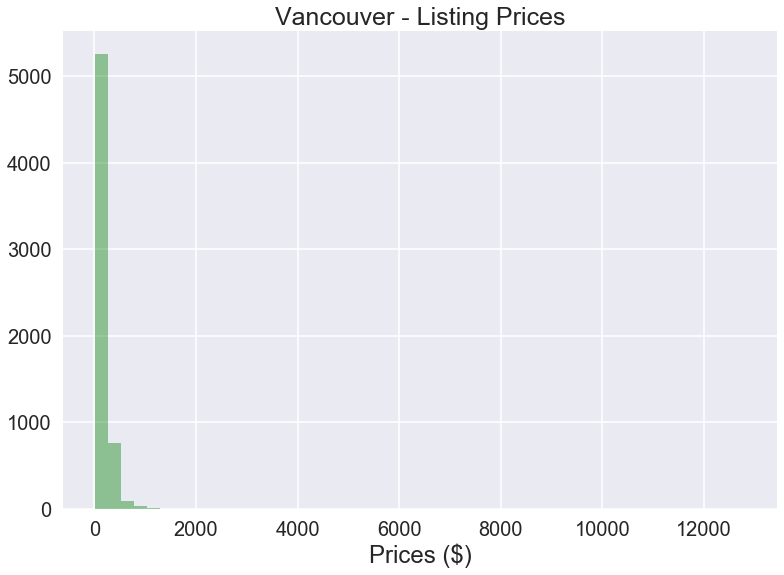

In [115]:
#Setup plot with title & axis
plot_histogram(Vancouver_price, 'price', binsize=50, x_label='Prices ($)', color='green')

In [92]:
#There appears to be a few very high value properties
Vancouver_price.nlargest(10, ['price'])

,price
listing_id,
35460289,12800
38418124,7946
28515801,3600
24622118,3500
37181228,3500
37538872,2500
26396221,2053
5089343,2000
35229456,1953


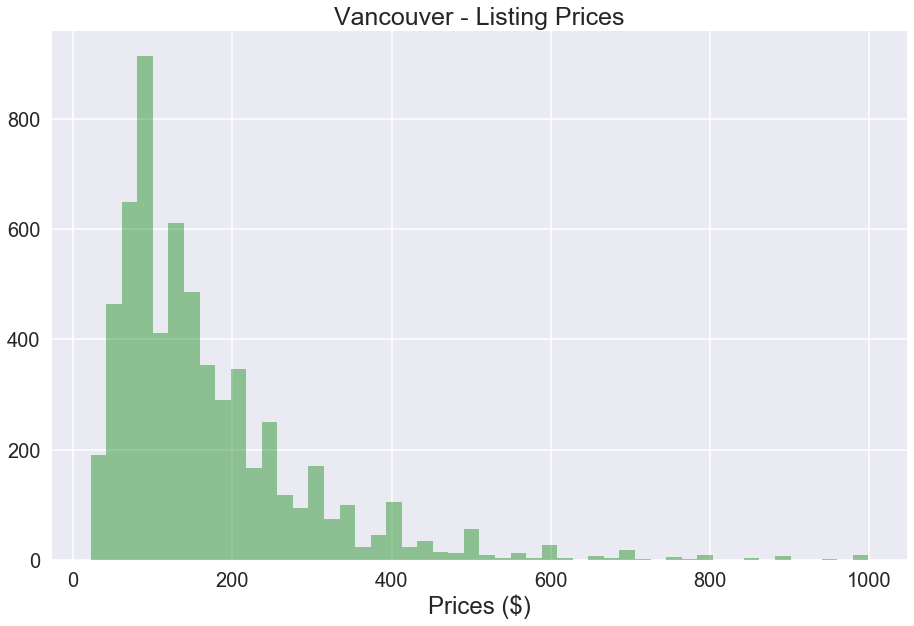

In [117]:
#Setup plot with title & axis
plot_histogram(Vancouver_price[Vancouver_price['price'] < 1000], 'price', binsize=50, x_label='Prices ($)', color='green')

The data shows that Vancouver has a few outliers (12800, 7946, etc) per night, which will skew the data sigificantly. Across the more moderate range of <1000/night there is a more intuitive spread, with a peak of ~100/night.

In [118]:
#Interpolate data to fill missing days for each property
Vancouver_Int = Vancouver_Cal_clean.groupby(['date', 'listing_id']).mean().unstack(level=1).interpolate().ffill().bfill()

#Take average value across all properties
Vancouver_ACPD = pd.DataFrame(Vancouver_Int.median(axis=1), columns = ['Price ($)'])

#Calculate cost per month across all properties
Vancouver_CPM = Vancouver_ACPD.resample('M').sum().round()

#Drop last month as not complete
Vancouver_CPM = Vancouver_CPM.iloc[:-1,:]

#Normalize dataF
Vancouver_CPM = Vancouver_CPM/Vancouver_CPM.max()*100

Vancouver_CPM.head(10)

,Price ($)
date,
2019-09-30,44.009434
2019-10-31,93.396226
2019-11-30,89.433962
2019-12-31,99.103774
2020-01-31,96.698113
2020-02-29,88.396226
2020-03-31,95.566038
2020-04-30,93.537736
2020-05-31,99.245283


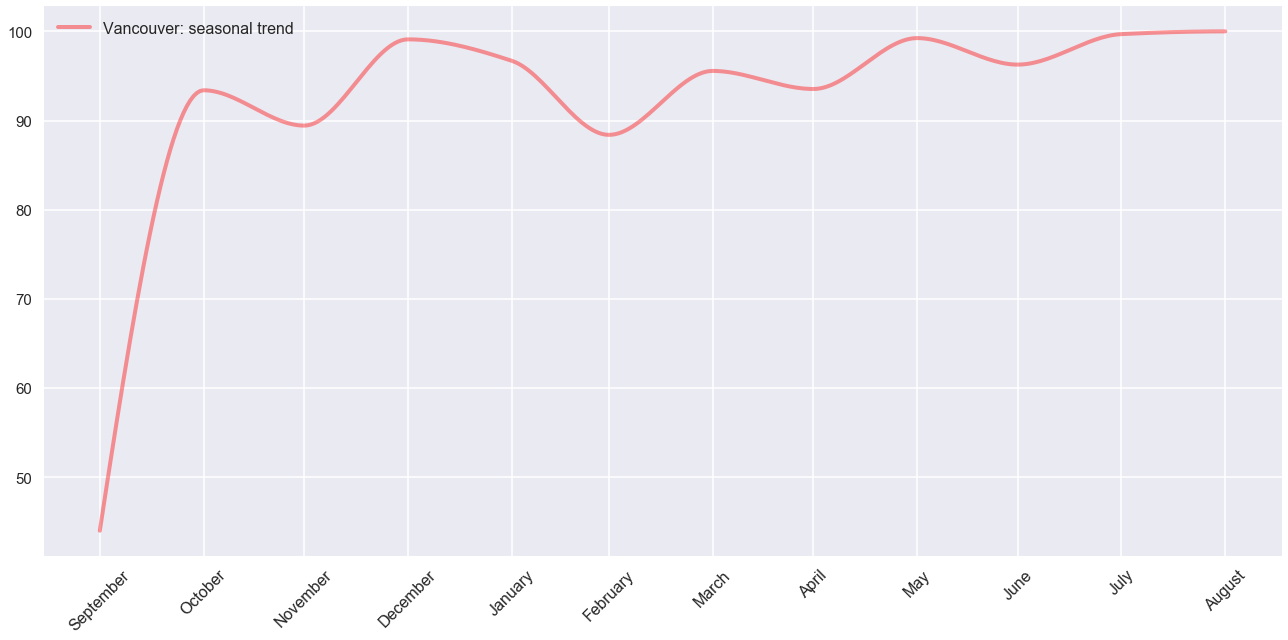

In [119]:
fig, ax = plt.subplots(figsize=(18,9))

plot_line(Vancouver_CPM.resample('1D').interpolate('pchip'), ax, color='red', 
          alpha=.4, ls='-', lw=4, label='Vancouver: seasonal trend')

___Answer: Does the price vary seasonally?___

There is a clear seasonal trend for low prices in the month of September. This is unexpected and could be looked across multiple years of data to determine if this is an anomaly.

# Machine Learning Pre-processing

Average price over the year is taken for each listing from calendar data, rather than the instantaneous price in listing data. Other features come from listing data.

In [272]:
#Merge calendar & Listing data
Vancouver_merged = data_merge(Vancouver_Cal_clean, Vancouver_List_clean)

#Drop redundant price feature from listings
Vancouver_drop = Vancouver_merged.drop(columns=['price'])

In [273]:
Vancouver_drop.head()

,Cal_price,neighbourhood,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
listing_id,,,,,,,,,,,,,,,,,,,,
5731,40,Kensington-Cedar Cottage,V5N 4H8,House,Private room,1,0.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free parking on pre...",103,90.0,9.0,9.0,10.0,9.0,9.0,9.0,0.81
10080,150,Coal Harbour,V6E 2P4,Condominium,Entire home/apt,6,2.0,2.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",16,93.0,9.0,9.0,10.0,9.0,10.0,9.0,0.17
13188,98,Riley Park,V5Y,Apartment,Entire home/apt,4,1.0,0.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",218,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.87
13357,126,Downtown Vancouver,V6B,Apartment,Entire home/apt,4,2.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",57,84.0,8.0,9.0,8.0,8.0,8.0,8.0,0.49
13490,145,Kensington-Cedar Cottage,V5N,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",83,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0.82


In [274]:
#What type of data is present?

Vancouver_drop.dtypes

Cal_price                        int64
neighbourhood                   object
zipcode                         object
property_type                   object
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
bed_type                        object
amenities                       object
number_of_reviews                int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
reviews_per_month              float64
dtype: object

Categorical data: ordinal(accomodates, bedrooms, etc), nominal(neighbourhood, zipcode, bed_type). Will need to encode these types.

In [275]:
#How complete is merged data?

pd.isnull(Vancouver_drop).sum()/len(Vancouver_drop)*100

Cal_price                       0.000000
neighbourhood                   0.000000
zipcode                         1.473446
property_type                   0.000000
room_type                       0.000000
accommodates                    0.000000
bathrooms                       0.032383
bedrooms                        0.032383
beds                            0.080959
bed_type                        0.000000
amenities                       0.000000
number_of_reviews               0.000000
review_scores_rating           13.196244
review_scores_accuracy         13.196244
review_scores_cleanliness      13.196244
review_scores_checkin          13.244819
review_scores_communication    13.212435
review_scores_location         13.244819
review_scores_value            13.244819
reviews_per_month              12.807642
dtype: float64

In [276]:
#Replace numerical category variables with mode
numeric_cata = ['review_scores_rating','accommodates','bathrooms','bedrooms','beds','review_scores_accuracy',
                'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                'review_scores_location','review_scores_value']

Vancouver_drop[numeric_cata] = Vancouver_drop[numeric_cata].fillna(Vancouver_drop.mode().iloc[0])

In [277]:
#Edit bad zip codes
Vancouver_drop['zipcode'] = [str(x)[:3] for x in Vancouver_drop['zipcode']]

#Drop neighbourhood as redundant with Zipcode
Vancouver_drop = Vancouver_drop.drop(columns = 'neighbourhood')

#Drop NaN's
Vancouver_drop = Vancouver_drop.dropna()

pd.isnull(Vancouver_drop).sum()/len(Vancouver_drop)*100

Cal_price                      0.0
zipcode                        0.0
property_type                  0.0
room_type                      0.0
accommodates                   0.0
bathrooms                      0.0
bedrooms                       0.0
beds                           0.0
bed_type                       0.0
amenities                      0.0
number_of_reviews              0.0
review_scores_rating           0.0
review_scores_accuracy         0.0
review_scores_cleanliness      0.0
review_scores_checkin          0.0
review_scores_communication    0.0
review_scores_location         0.0
review_scores_value            0.0
reviews_per_month              0.0
dtype: float64

Now all NaN's have been removed, edit amenities column and perform one hot encoding on all categorical variables.

In [278]:
#Seperate anemities into list
Vancouver_drop['amenities'] = [x.replace('{','').replace('}','').replace('"','').split(',')
                               for x in Vancouver_drop['amenities']]

In [279]:
#One hot encode the amenities
mlb = MultiLabelBinarizer()
amenities = pd.DataFrame(mlb.fit_transform(Vancouver_drop.pop('amenities')), columns = mlb.classes_,
                         index=Vancouver_drop.index)

amenities.head()

,toilet,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,Amazon Echo,BBQ grill,Baby bath,Baby monitor,...,Wide doorway to guest bathroom,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,Wine cooler,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
listing_id,,,,,,,,,,,,,,,,,,,,,
5731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10080,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
13188,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
13357,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
13490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1


In [280]:
amenities.head()

,toilet,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,Amazon Echo,BBQ grill,Baby bath,Baby monitor,...,Wide doorway to guest bathroom,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,Wine cooler,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
listing_id,,,,,,,,,,,,,,,,,,,,,
5731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10080,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
13188,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
13357,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
13490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1


In [281]:
amenities = amenities.drop('translation missing: en.hosting_amenity_49', 1)
amenities = amenities.drop('translation missing: en.hosting_amenity_50', 1)

amenities.head()

,toilet,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,Amazon Echo,BBQ grill,Baby bath,Baby monitor,...,Wheelchair accessible,Wide clearance to shower,Wide doorway to guest bathroom,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,Wine cooler
listing_id,,,,,,,,,,,,,,,,,,,,,
5731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10080,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13188,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
13357,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
13490,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


One hot encoding for other non-numeric features

In [282]:
non_numeric_data = ['zipcode', 'property_type', 'room_type', 'bed_type']

In [283]:
#get dummies for this non-numerica data
nn_cata = pd.get_dummies(Vancouver_drop[non_numeric_data])

Reconstitue the dataset with the above

In [284]:
Vancouver_input = Vancouver_drop.drop(columns=['zipcode', 'property_type','room_type', 'bed_type'])

Vancouver_join_temp = pd.merge(Vancouver_input, nn_cata, left_index=True, right_index=True)
Vancouver_join = pd.merge(Vancouver_join_temp, amenities, left_index=True, right_index=True)

In [285]:
Vancouver_join.head()

,Cal_price,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,Wheelchair accessible,Wide clearance to shower,Wide doorway to guest bathroom,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,Wine cooler
listing_id,,,,,,,,,,,,,,,,,,,,,
5731,40,1,0.0,1.0,1.0,103,90.0,9.0,9.0,10.0,...,0,0,0,0,0,0,0,1,0,0
10080,150,6,2.0,2.0,4.0,16,93.0,9.0,9.0,10.0,...,0,0,0,0,0,0,0,1,0,0
13188,98,4,1.0,0.0,2.0,218,96.0,10.0,10.0,10.0,...,0,0,0,0,0,0,0,1,0,0
13357,126,4,2.0,2.0,2.0,57,84.0,8.0,9.0,8.0,...,1,0,0,0,0,0,0,1,0,0
13490,145,2,1.0,1.0,1.0,83,98.0,10.0,10.0,10.0,...,1,0,0,0,0,0,0,1,0,0


In [294]:
#All of the above can be refactored into a module to use in a modelling notebook

def ML_preprocessing(calendar_data, listings_data):
    #Initial clean up of data
    cal_cleaned = clean_calendar_data(calendar_data)
    list_cleaned = clean_listing_data(listings_data)
    
    #Merge calendar & Listing data
    data_merged = data_merge(cal_cleaned, list_cleaned)

    #Drop redundant features from listings
    data_drop = data_merged.drop(columns=['price', 'neighbourhood'])
    
    #Replace numerical category variables with mode
    numeric_cata = ['review_scores_rating','accommodates','bathrooms','bedrooms','beds','review_scores_accuracy',
                    'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                    'review_scores_location','review_scores_value']

    data_drop[numeric_cata] = data_drop[numeric_cata].fillna(data_drop.mode().iloc[0])
    
    #Edit bad zip codes
    data_drop['zipcode'] = [str(x)[:3] for x in data_drop['zipcode']]
    
    #Drop NaN's
    data_drop = data_drop.dropna()
    
    #Seperate anemities into list
    data_drop['amenities'] = [x.replace('{','').replace('}','').replace('"','').split(',')
                               for x in data_drop['amenities']]
    
    #One hot encode the amenities & drop meaningless features
    mlb = MultiLabelBinarizer()
    amenities = pd.DataFrame(mlb.fit_transform(data_drop.pop('amenities')), columns = mlb.classes_,
                         index=data_drop.index)
    
    #Specific to vancouver dataset
    amenities = amenities.drop('translation missing: en.hosting_amenity_49', 1)
    amenities = amenities.drop('translation missing: en.hosting_amenity_50', 1)
    
    #get dummies for this non-numerica data
    non_numeric_data = ['zipcode', 'property_type', 'room_type', 'bed_type']
    nn_cata = pd.get_dummies(data_drop[non_numeric_data])
    
    #Merge the dataframes and drop extra columns to create the ML input
    data_temp = pd.merge(data_drop, nn_cata, left_index=True, right_index=True)
    data_output = pd.merge(data_temp, amenities, left_index=True, right_index=True)
    data_output = data_output.drop(columns=['zipcode', 'property_type','room_type', 'bed_type'])
    
    
    return data_output

Verify that refactoring works

In [295]:
test_van = ML_preprocessing(Vancouver_Cal, Vancouver_List)

Columns dropped: {'monthly_price', 'weekly_price', 'square_feet'}
Number of rows dropped: 0


In [298]:
test_van.head()

,Cal_price,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,Wheelchair accessible,Wide clearance to shower,Wide doorway to guest bathroom,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,Wine cooler
listing_id,,,,,,,,,,,,,,,,,,,,,
5731,40,1,0.0,1.0,1.0,103,90.0,9.0,9.0,10.0,...,0,0,0,0,0,0,0,1,0,0
10080,150,6,2.0,2.0,4.0,16,93.0,9.0,9.0,10.0,...,0,0,0,0,0,0,0,1,0,0
13188,98,4,1.0,0.0,2.0,218,96.0,10.0,10.0,10.0,...,0,0,0,0,0,0,0,1,0,0
13357,126,4,2.0,2.0,2.0,57,84.0,8.0,9.0,8.0,...,1,0,0,0,0,0,0,1,0,0
13490,145,2,1.0,1.0,1.0,83,98.0,10.0,10.0,10.0,...,1,0,0,0,0,0,0,1,0,0


This function is ready to be used as an input to a ML model